In [1]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "cell_detection_dataset")
if not os.path.exists(dataset_path):
    url = "http://data.celltrackingchallenge.net/training-datasets/BF-C2DL-HSC.zip"
    download_url(url, ".")
    _extract_zip("BF-C2DL-HSC.zip", dataset_path, None)
    os.remove("BF-C2DL-HSC.zip")

base_dir = os.path.join(dataset_path, "BF-C2DL-HSC")

In [2]:
import deeptrack as dt
import glob
import skimage.measure

dt.config.disable_image_wrapper()

sources = dt.sources.Source(
    image_path=sorted(glob.glob(os.path.join(base_dir, "02", "*.tif"))),
    label_path=sorted(glob.glob(os.path.join(base_dir, "02_GT", "TRA", "*.tif"))),
)

image = dt.LoadImage(sources.image_path)[:, :300] / 256
label = dt.LoadImage(sources.label_path)[:, :300] >> skimage.measure.regionprops

pipeline = image & label

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


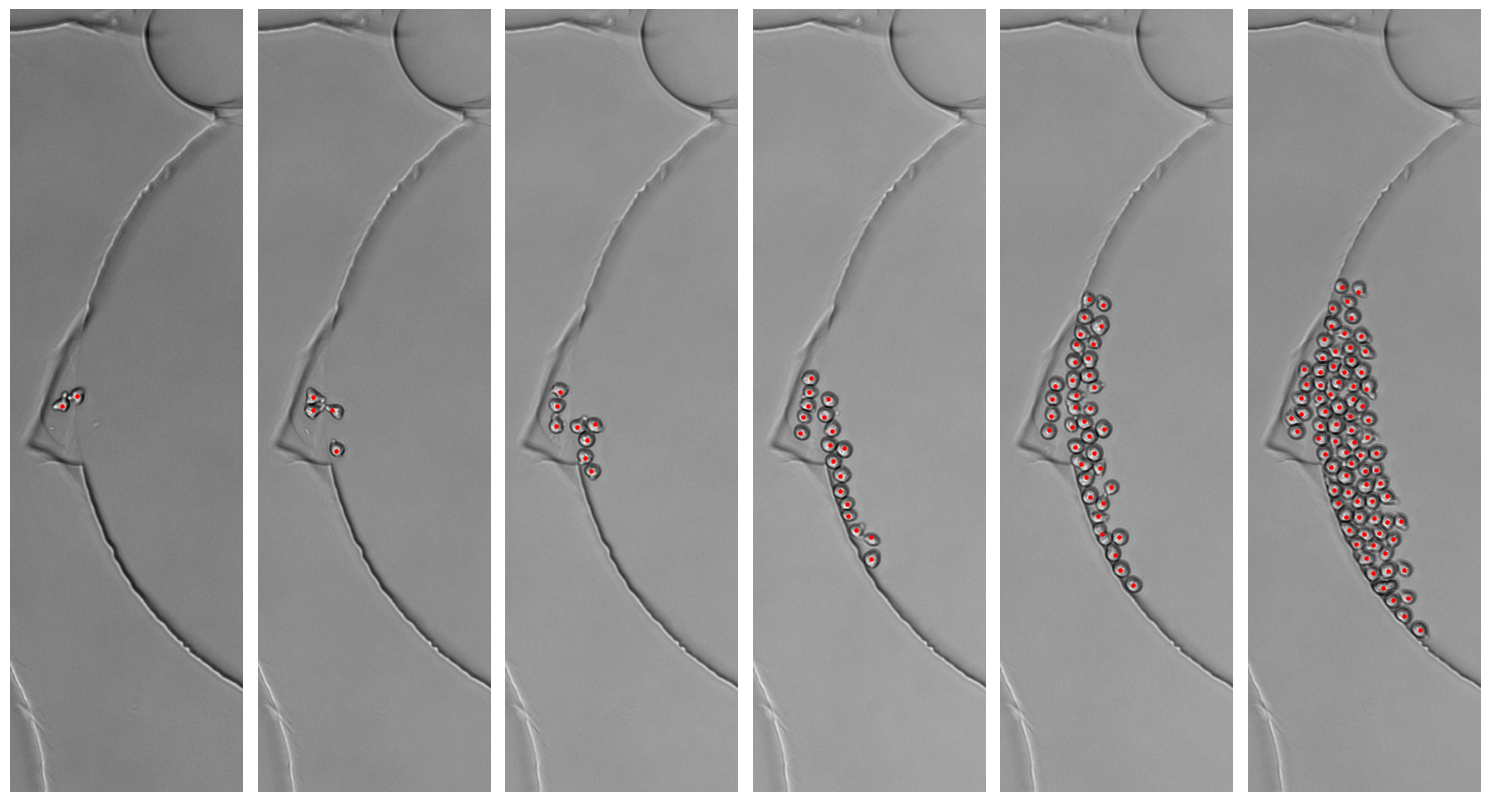

In [3]:
import matplotlib.pyplot as plt
import skimage.io

plt.figure(figsize=(15, 10))

for plt_index, data_index in enumerate([0, 300, 600, 900, 1200, 1500]):
    image, *props = pipeline(sources[data_index])
    
    plt.subplot(1, 6, plt_index + 1)
    plt.imshow(image, cmap="gray")
    for prop in props:
        plt.scatter(prop.centroid[1], prop.centroid[0], s=5, color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()

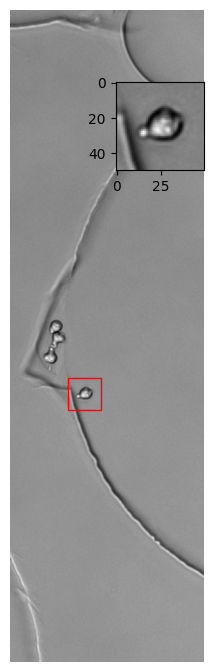

In [4]:
import matplotlib.patches as patches

crop_frame_index = 282
crop_size = 50
crop_x0 = 595 - crop_size // 2
crop_y0 = 115 - crop_size // 2

image, *props = pipeline(sources[crop_frame_index])
crop = image[crop_x0 : crop_x0 + crop_size, crop_y0 : crop_y0 + crop_size]


fig = plt.figure(figsize=(2.5, 10))
plt.imshow(image, cmap="gray")
plt.gca().add_patch(
    patches.Rectangle(
        (crop_y0, crop_x0),
        crop_size,
        crop_size,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
)
plt.axis("off")

fig.add_subplot(2, 2, 2)
plt.imshow(crop, cmap="gray")

In [5]:
import numpy as np
import torch
training_pipeline = (
    dt.Value(crop)
    >> dt.Multiply(lambda: np.random.uniform(0.95, 1.05))
    >> dt.Add(lambda: np.random.uniform(-0.05, 0.05))
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, replace=False)

In [6]:
import deeplay as dl 
dataloader = dl.DataLoader(training_dataset, batch_size=4, shuffle=True)

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [7]:

model = dl.applications.LodeSTAR(
    n_transforms=8, 
    optimizer=dl.Adam(lr=1e-4),
    within_loss_weight=100,
).build()

trainer = dl.Trainer(max_epochs=20)
trainer.fit(model, dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generat

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


(-16.344245427846907, 317.39305221438406, 1009.5, -54.581374526023865)

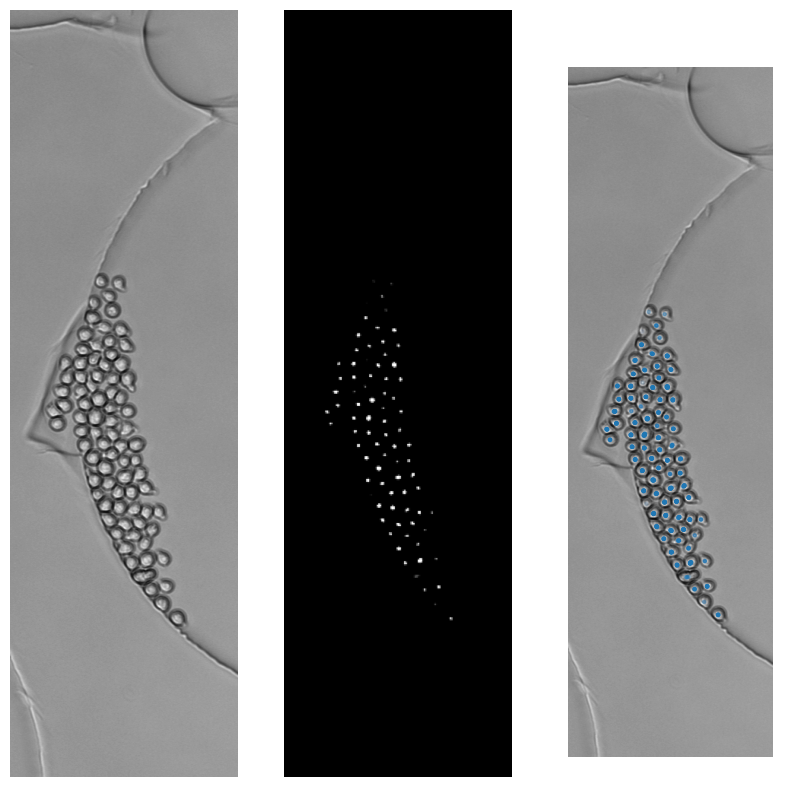

In [8]:
image_index = 1500

image, *props = pipeline(sources[image_index])

torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()

prediction = model(torch_image)[0].detach().numpy()

x_feature = prediction[0]
y_feature = prediction[1]
mass_feature = prediction[-1]

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mass_feature, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image, cmap="gray")
plt.scatter(
	y_feature.flatten(), 
	x_feature.flatten(), 
	alpha=mass_feature.flatten() / mass_feature.max(),
	s=5,
)
plt.axis("off")

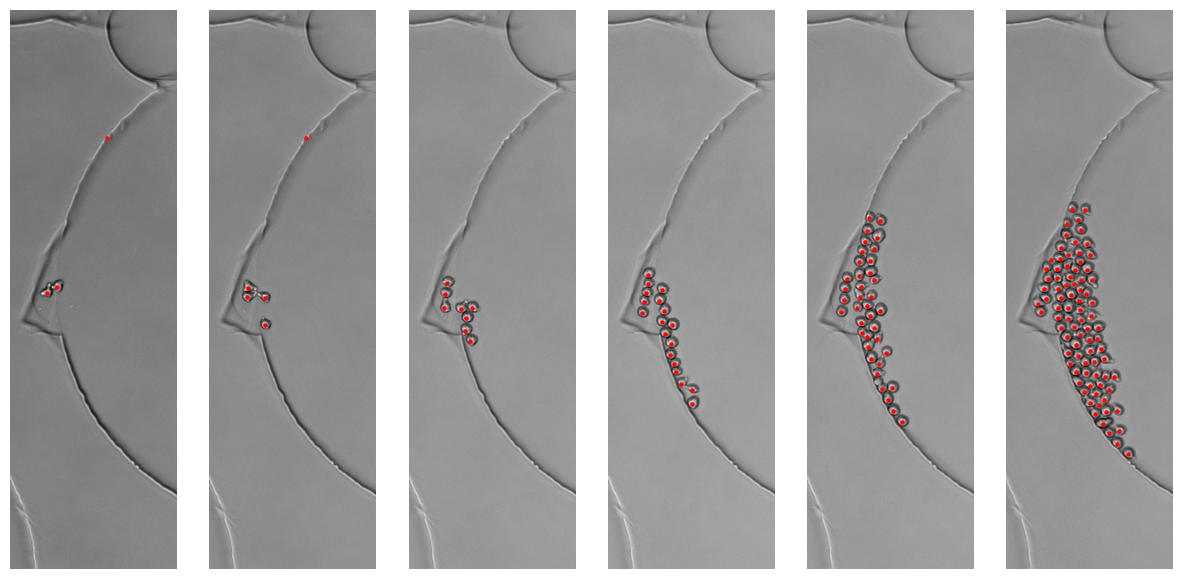

In [9]:
plt.figure(figsize=(15, 10))

for plot_idx, frame_idx in enumerate([0, 300, 600, 900, 1200, 1500]):
    image, *props = pipeline(sources[frame_idx])
    torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    y = model(torch_image.to(model.device))
    y_pred, weights = y[:, :-1], y[:, -1:]
    detections = model.detect(torch_image,
                              alpha=0.1,
                              beta=0.9,
                              mode="constant",
                              cutoff=.2)[0]

    plt.subplot(1, 6, plot_idx + 1)
    plt.imshow(image, cmap="gray")
    plt.scatter(
        detections[:, 1],
        detections[:, 0],
        s=5,
        color="red",
    )
    plt.axis("off")

In [10]:
import tqdm 
import scipy

distance_th = 10

TP = 0
FP = 0
FN = 0

for source in tqdm.tqdm(sources[::10]):
    image, *props = pipeline(source)
    torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    detections = model.detect(torch_image,
                              alpha=0.1,
                              beta=0.9,
                              mode="constant",
                              cutoff=.2)[0]
    
    centroids = np.array([prop.centroid[:2] for prop in props])

    distance_matrix = scipy.spatial.distance_matrix(detections, centroids)
    row_idx, col_idx = scipy.optimize.linear_sum_assignment(distance_matrix)

    filtered_row_ind = row_idx[distance_matrix[row_idx, col_idx] < distance_th]
    filtered_col_ind = col_idx[distance_matrix[row_idx, col_idx] < distance_th]

    TP += len(filtered_row_ind)
    FP += len(detections) - len(filtered_row_ind)
    FN += len(centroids) - len(filtered_col_ind)

f1 = 2 * TP / (2 * TP + FP + FN)

print(f"""
TP: {TP}
FP: {FP}
FN: {FN}
F1: {f1}  
""")

100%|██████████| 177/177 [00:51<00:00,  3.47it/s]


TP: 6436
FP: 306
FN: 39
F1: 0.9738972535371113  

